In [1]:
pip install pylatexenc

Note: you may need to restart the kernel to use updated packages.


# Surface Codes Tutorial I

In this notebook we're going to take a look at one of the most widely used and well studied forms of quantum error correction and fault tolerant quantum computing, surface codes. Surface codes are a way of encoding logical qubits into several physical qubits and use topological properties of the connectivity of the qubits to protect against errors. One connection we will need to make clear from the beginning is a connection to number theory and combinatorial topology via so-called "ribbon graphs" or "dessins d'enfants". 

Let's import a few things we will need. 

In [2]:
from typing import Tuple, List, Union, Any, Dict

#from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
#from qiskit.circuit.measure import measure
#from networkx import nx
#import qiskit
#from sympy.combinatorics import Permutation


import networkx as nx
from networkx.classes.multigraph import MultiGraph
from networkx.algorithms import bipartite
from sympy.combinatorics import Permutation, PermutationGroup
from qiskit import *

Now, we define the following Python function to compute measurements in the Pauli $X$-basis rather than in the $Z$-basis. Remember, If we conjugate the $Z$-operator by Hadamard gates, we get an $X$-gate,

$$HZH^{\dagger} = HZH = X.$$

So, if we want to measure in the $X$-basis we need this conjugation.

In [3]:
def x_measurement(circuit: qiskit.circuit.QuantumCircuit, qubit: int, cbit: int):
    """Measure 'qubit' in the X-basis, and store the result in 'cbit'"""
    # circuit.measure = measure  # fix a bug in qiskit.circuit.measure
    circuit.h(qubit)
    circuit.measure(qubit, cbit)
    circuit.h(qubit)
    return circuit

Let's have a quick look at a circuit in Qiskit that uses the $X$-basis measurement.

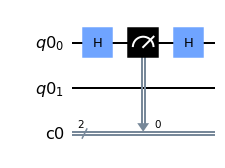

In [4]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
circ = QuantumCircuit(qr, cr)
x_measurement(circ, 0, 0)
circ.draw(output = 'mpl')

## Graphs on Surfaces

Now, we are going to need a combinatorial tool often called a **dessin d'enfant, ribbon graph, combinatorial map, or rotation systems**. The term dessin d'enfant is a French term meaning "child's drawing" which was introduced by Alexander Grothendieck in the contect of studying number theory, alegraic geomerty, and Riemann surfaces, so it is often most used in these constexts. The term "ribbon graph" is more often used by the physics community, but these are all essentially equivalent notions. This combinatorial tool shows up in the context of studying quantum gravity, for example in a paper by Maxim Kontsevich "Intersection Theory on the Moduli Space of Curves and the Matrix Airy Function". Other examples can be found in the work of Edward Witten, for example in "Volumes and Random Matrices and Developments in Topological Gravity".

So, how does one define a dessin/ribbon graph? Well, one way is through two permutations from the group $S_{2n}$, the symmetric group of order $2n$. This is the approach taken in "[Graphs on Surfaces and Their Applications](https://www-users.cse.umn.edu/~reiner/Classes/Math8680Fall2014Papers/LandoZvonkin.pdf)" (see pg. 7), a very important referefence for this notebook. We define two permutations, $\sigma, \alpha$ such that $\sigma, \alpha \in S_{2n}$. The permutation $\phi = (\sigma \alpha)^{-1}$ then gives us a triple $[\sigma, \alpha, \phi]$ which defines a **constellation**. A constellation is a slightly more general object defined as follows:

A sequence of permutations $[g_1, ..., g_k]$ with $g_i \in S_{n}$ such that:

- the group $G = \langle g_1, ..., g_k \rangle$, generated by the $g_i$ acts transitively on the set of $n$ points.

- $g_1 g_2 \cdots g_k = \mathbf{id}$

is called a **constellation**. The integer $n$ is called the degree of the constellation, and $k$ is called its length. There is a correspondence between a graph on a surface and constellations:

$$
\text{vertex of graph} \leftrightarrow \text{cycle of } \sigma \\
\text{edge of graph} \leftrightarrow \text{cycle of } \alpha \\
\text{face of graph} \leftrightarrow \text{cycle of } \phi. 
$$

Using the above correspondence we can compute the genus  of the graph embedded in the surface using the formula

$$
V-E+F = 2-2g.
$$
 
There is a notion of a dual graph where each face of the graph is replaced by a vertex, and these vertices are connected by an edge in the dual graph if and only if the correspond to two faces that were separated by an edge before in the original graph. This replacement also automatically means every vertex in the original grapht is replaced by a face in the dual graph. The dual graph lies on the same surface and thus has the same genus. Moreover, we can compute the corresponding constellation by simply exchanging $\sigma$ and $\phi$. The notion of a dual graph will be important in the construction of surface codes because the qubits in a surface code will correspond to the vertices, edges, and faces of a dessin and its dual graph, just as the dual graph is used in [Quantum Computation with Topological Codes: from qubit to topological fault-tolerance](https://arxiv.org/pdf/1504.01444.pdf), another very important reference for this notebook. Our construction will provide usual surface codes, just as those defined in this reference, but we also provide a way of constructing hybrid qudit surface codes, a new less written about kind of surface code. 

## Permutations in SymPy
While ribbon graphs and many useful methods for them are implemented in [SageMath](https://doc.sagemath.org/html/en/reference/discrete_geometry/sage/geometry/ribbon_graph.html), we prefer to implement the combinatorics again for instructive purposes. [SymPy](https://docs.sympy.org/latest/modules/combinatorics/permutations.html) offers a way of computing with permutations that will be helpful. We can import what we need from SymPy as follows:

In [5]:
from sympy.combinatorics import Permutation, PermutationGroup

Now, let's write some Python code that we will need to create graphs embedded in surfaces. The following Python function will take as input the permutations $\sigma$ and $\alpha$ in the form of a list of lists, or as a tuple of tuples. It will then compute the list of lists form of the permutation $\phi$. SymPy allows multiplication of permutation (composition) and it allows us to compute inverses as well. Let's look at an example.

In [6]:
sigma = [[0,1,2],[3,4,5]]
s = Permutation(sigma)
s

Permutation(0, 1, 2)(3, 4, 5)

In [7]:
alpha = [[0,3],[1,4],[2,5]]
a = Permutation(alpha)
a

Permutation(0, 3)(1, 4)(2, 5)

Let's compute the product (composition) of `a` and `s`, which in SymPy means perform `a`, then perform `s`.

In [8]:
p = a*s
p

Permutation(0, 4, 2, 3, 1, 5)

Now let us compute the inverse of `p`. 

In [9]:
~p

Permutation(0, 5, 1, 3, 2, 4)

Now, let us write a function (method) to compute $\phi$ (or `~p`):

In [10]:
def compute_phi(sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]) -> List[List[int]]:
    """compute the list of lists full cyclic form of phi (faces of dessin [sigma, alpha, phi])"""
    s = Permutation(sigma)
    a = Permutation(alpha)
    f = ~(a * s)
    f = f.full_cyclic_form # prints permutation as a list of lists including all singletons (fixed points)
    return f

Again, as an example take the $\sigma=$ `s` $=$ `sigma` and $\alpha=$ `a` $=$ `alpha` acting on the set of points $\{0,1,2,3,4,5\}$. 

In [11]:
sigma = [[0,1,2],[3,4,5]]
alpha = [[0,3],[1,4],[2,5]]
compute_phi(sigma, alpha)

[[0, 5, 1, 3, 2, 4]]

Notice, we get the same thing as we computed above when we computed `~p`, except this time it's in the form of a list of lists. The next function will take a permutation as an input and it will convert it to a tuple of tuples.

In [12]:
def permlist_to_tuple(perms):
    """
    convert list of lists to tuple of tuples in order to have two level iterables
    that are hashable for the dictionaries used later
    """
    perm_list = list()
    for perm in perms:
        perm = tuple(perm)
        perm_list.append(perm)
    return tuple(perm_list)

As an example, let's give it the permutation $\sigma$.

In [13]:
permlist_to_tuple(sigma)

((0, 1, 2), (3, 4, 5))

This will be useful if we need to iterate on two levels. Next, we define a function that computes the graph corresponding to the constellation $[\sigma, \alpha, \phi]$, along with its dual graph corresponding to $[\phi, \alpha, \sigma]$. For this function we need [NetworkX](https://networkx.org/) for handling graphs and networks.

In [14]:
def build_node_info(sigma, alpha, phi):
    count = -1
    
    sigma_dict = dict()
    for count, cycle in enumerate(sigma):
        sigma_dict[cycle] = count
        
    phi_dict = dict()
    for count, cycle in enumerate(phi, start=count + 1):
        phi_dict[cycle] = count
        
    alpha_dict = dict()
    for count, pair in enumerate(alpha, start=count + 1):
        alpha_dict[pair] = count
        
    return sigma_dict, alpha_dict, phi_dict

In [15]:
def surface_code_graph(sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]) -> \
        Tuple[Union[nx.MultiGraph, Any], Tuple[Dict[Any, int], Dict[Any, int], Dict[Any, int]]]:
    """output a graph and a node_info"""
    f = compute_phi(sigma, alpha)
    phi = permlist_to_tuple(f)

    surface_graph = nx.MultiGraph()

    node_info = build_node_info(sigma, alpha, phi)

    # Create nodes for each cycle in sigma
    for cycle in sigma:
        surface_graph.add_node(cycle, bipartite=1)
        for node in cycle:
            surface_graph.add_node(node, bipartite=0)
            surface_graph.add_edge(cycle, node)

    # Create nodes for each cycle in phi
    for cycle in phi:
        surface_graph.add_node(cycle, bipartite=1)
        for node in cycle:
            surface_graph.add_edge(cycle, node)

    # Create nodes for each cycle in alpha
    # then glue the nodes corresponding to a the pairs
    for pair in alpha:
        surface_graph.add_node(pair)
        surface_graph = nx.contracted_nodes(surface_graph, pair[0], pair[1], self_loops=True)
        surface_graph = nx.contracted_nodes(surface_graph, pair, pair[0], self_loops=True)

    return surface_graph, node_info

In [16]:
sigma1 = ((0,1,2),(3,4,5))
alpha1 = ((0,3),(1,4),(2,5))
SC1, node_info = surface_code_graph(sigma1, alpha1)

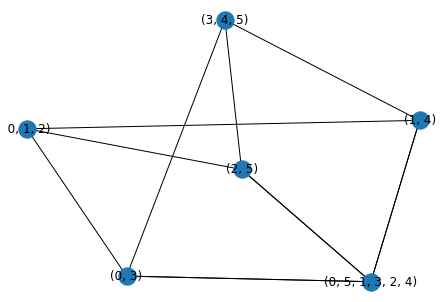

In [17]:
nx.draw(SC1, with_labels = True)

Notice there is a single **face** node $(0,5,1,3,2,4)$, which corresponds to a single face of the graph embedded in the surface. There are three **edge** nodes $(0,3), (2,5),$ and $(1,4)$. Often these nodes are white instead of black in the literature on dessins d'enfants. This makes the graph bipartite, and in general any bipartite graph can be realized in this way (via a constellation giving a graph embedded in a surface). There are two **vertex** nodes, $(0,1,2)$ and $(3,4,5)$. 

Although the graph is not drawn on a surface we can compute its genus using the formula

$$
V-E+F = |\sigma|-|\alpha|+|\phi| = 2-2g. 
$$

In this case we have two cycles in $\sigma$, three in $\alpha$, and one in $\phi$ giving us,

$$
2-3+1 = 0 = 2-2g \\ 
\implies g = 1.
$$

![Genus](genus.png "Genus")

A genus  surface is a torus. If you are not familiar with genus you might want to check out the [Wikipedia page](https://en.wikipedia.org/wiki/Genus_(mathematics)) where this image is taken from, and where the genus of a graph is defined as:

```
The genus of a graph is the minimal integer n such that the graph can be drawn without crossing itself on a sphere with n handles (i.e. an oriented surface of genus n). Thus, a planar graph has genus 0, because it can be drawn on a sphere without self-crossing.
```

It may also be useful to read the Wikipedia page on [graph embeddings](https://en.wikipedia.org/wiki/Graph_embedding). Although finding the genus of an arbitrary graph is an NP-hard problem, in the case of dessins (combinatorial embeddings), computing the genus is an easy task because of the way the graph is encoded in the permutations of the constellation $[\sigma, \alpha, \phi]$.

Let's have a look at another example. Here we will take

$$
\sigma = (0,1,2,3)(4,5,6,7) \\
\alpha = (0,3)(1,4)(2,5)(6,7).
$$

We can compute $\phi$ as follows:

In [18]:
sigma2 = ((0,1,2,3),(4,5,6,7))
alpha2 = ((0,3),(1,4),(2,5),(6,7))
compute_phi(sigma2, alpha2)

[[0], [1, 3, 5], [2, 4, 6], [7]]

Now, notice that the singleton permutations $(0)$ and $(7)$ are not normally printed. If we instead print the permutation version of this, we still only get a partial list of singletons and $(0)$ is left out again.

In [19]:
sigma2 = ((0,1,2,3),(4,5,6,7))
alpha2 = ((0,3),(1,4),(2,5),(6,7))
s = Permutation(sigma2)
a = Permutation(alpha2)
f = ~(a*s)
f

Permutation(7)(1, 3, 5)(2, 4, 6)

In order to get all of the singletons, we must print the `full_cyclic_form` of the permutation.

In [20]:
f.full_cyclic_form

[[0], [1, 3, 5], [2, 4, 6], [7]]

This can be converted to a tuple so that we can do a two-level iteration over it (iterable of iterables).

In [21]:
permlist_to_tuple(f.full_cyclic_form)

((0,), (1, 3, 5), (2, 4, 6), (7,))

The `full_cyclic_form` of the permutation is the appropriate form to build graphs on surfaces. This is because singletons correspond to loops in the graph. NetworkX doesn't always do the greatest job of drawing multiple edges and loops, however, we can still deal with them mathemtaically and build quantum circuits off of such graphs. Let's look at another example of a graph with loops (which aren't rendered appropriately by NetworkX), corresponding to the permutations we just computed. This graph will have genus given by,

$$
V-E+F = 2-4+4 = 2\\
= 2-2g \\
\implies g = 0.
$$

In [22]:
sigma2 = ((0,1,2,3),(4,5,6,7))
alpha2 = ((0,3),(1,4),(2,5),(6,7))
SC2, node_info = surface_code_graph(sigma2, alpha2)

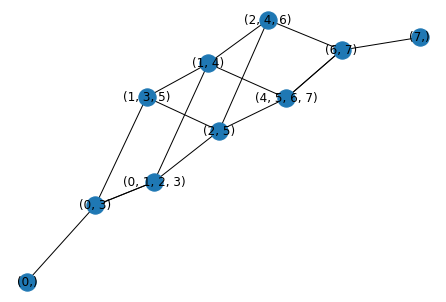

In [23]:
nx.draw(SC2, with_labels = True)

Let's draw this in another way.

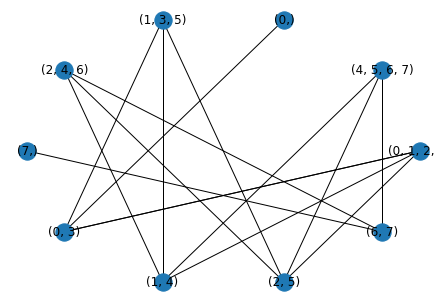

In [24]:
nx.draw_circular(SC2, with_labels = True)

## Surface Code Circuits

The next function we will write will build a quantum circuit based on a graph. It will create one qubit for every vertex, as well as a classical bit in which to store measurements for each vertex. It will return a triple: `circuit, node_dict, graph`. The `node_dict` is a dictionary the function builds to map the nodes in `graph` to the qubits of `circuit`.

In [25]:
def surface_code_circuit(sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]) -> \
        Tuple[QuantumCircuit, Union[nx.MultiGraph, Any], Tuple[Dict[Any, int], Dict[Any, int], Dict[Any, int]]]:
    
    surface_graph, node_info = surface_code_graph(sigma, alpha)

    '''
    Compute the permutation corresponding to phi and create a 
    'surface code circuit' based on a (multi)graph 'surface_graph'
    given by sigma, alpha, and phi
    Create quantum and classical registers based on the number of nodes in G
    '''
    f = compute_phi(sigma, alpha)
    phi = permlist_to_tuple(f)

    qr = QuantumRegister(len(surface_graph.nodes))
    cr = ClassicalRegister(len(surface_graph.nodes))
    circ = QuantumCircuit(qr, cr)
    
    sigma_dict, alpha_dict, phi_dict = node_info
    
    for cycle in sigma:
        circ.h(sigma_dict[cycle])

    for cycle in phi:
        circ.h(phi_dict[cycle])

    return circ, surface_graph, node_info

Now, let's create a graph based on the permutations

$$
\sigma = (0,5,1,3,2,4)\\
\alpha = (0,3)(1,4)(2,5).
$$

In [26]:
sigma = ((0,5,1,3,2,4),)
# Why is there a comma at the end of sigma?
alpha = ((0,3),(1,4),(2,5))
compute_phi(sigma, alpha)

[[0, 1, 2], [3, 4, 5]]

In [27]:
G, node_info = surface_code_graph(sigma, alpha)
node_info

({(0, 5, 1, 3, 2, 4): 0},
 {(0, 3): 3, (1, 4): 4, (2, 5): 5},
 {(0, 1, 2): 1, (3, 4, 5): 2})

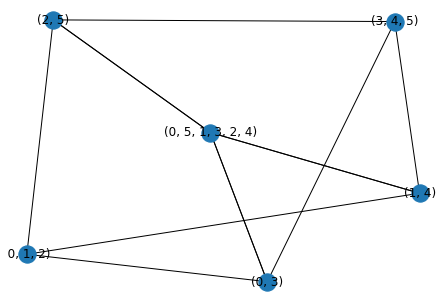

In [28]:
nx.draw(G, with_labels = True)

Now, let's build a circuit using our function surface_code_circuit().

In [29]:
circuit, node_dict, G = surface_code_circuit(sigma, alpha)

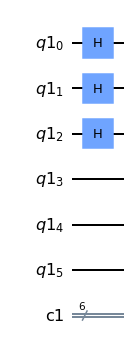

In [30]:
circuit.draw(output = 'mpl')

## Star Syndrome Measurements
Now, we want to define something known as a syndrome measurement. This is defined on pg. 108 in Quantum Computation with Topological Codes: from qubit to topological fault-tolerance. The following visualization is given there.

![Star_Syndrome](star_syndrome.png "Star_Syndrome")

Notice there is an **ancilla qubit** located on the node of a face corresponding to a cycle in $\phi$ on the left, as well as an ancilla qubit located at the node corresponding to a cycle of $\sigma$ on the right. These are two types of syndrom measurements that we will now define. The following function defines the **syndrome measurement** pictured on the right, corresponding to a vertex given by a cycle of $\sigma$. These are called **star syndrome measurements**.

In [31]:
def star_syndrome_measure(circuit: qiskit.circuit.QuantumCircuit, surface_graph: nx.MultiGraph,
                          node_info, vertex: Tuple[int]):
    v = vertex
    
    sigma_dict, alpha_dict, phi_dict = node_info
    
    for node in surface_graph.neighbors(v):
        circuit.cx(sigma_dict[v], alpha_dict[node])

    circuit.barrier()
    x_measurement(circuit, sigma_dict[v], sigma_dict[v])
    circuit.barrier()

    return circuit, surface_graph, node_info

Let's build a surface code from the graph given by the constellation,

$$
\sigma = (0,1,2)(3,4,5) \\
\alpha = (0,3)(1,4)(2,5)
$$

and perform the star syndrome measurement corresponding to the vertex $(0,1,2)$.

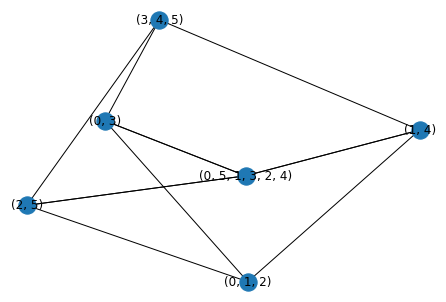

In [32]:
sigma = ((0,1,2),(3,4,5))
alpha = ((0,3),(1,4),(2,5))
G, node_info = surface_code_graph(sigma, alpha)
nx.draw(G, with_labels = True)

The following will build the circuit we need.

In [33]:
SCC, G, node_info = surface_code_circuit(sigma, alpha)
SCC, G, node_info

(<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7ffbf232a880>,
 ({(0, 1, 2): 0, (3, 4, 5): 1},
  {(0, 3): 3, (1, 4): 4, (2, 5): 5},
  {(0, 5, 1, 3, 2, 4): 2}))

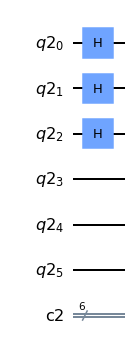

In [34]:
SCC.draw(output = 'mpl')

Next, we perform the star syndrom measurement for the qubit corresponding to the vertex $(0,1,2)$. 

In [35]:
v = (0,1,2)
SCC, G, node_info = star_syndrome_measure(SCC, G, node_info, v)

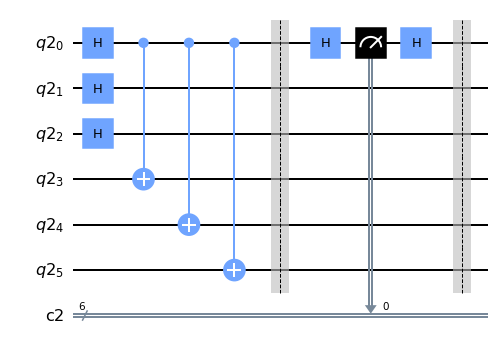

In [36]:
SCC.draw(output = 'mpl')

Next, we perform the star syndrome measurement corresponding to the vertex $(3,4,5)$.

In [37]:
w = (3,4,5)
SCC, G, node_info = star_syndrome_measure(SCC, G, node_info, w)

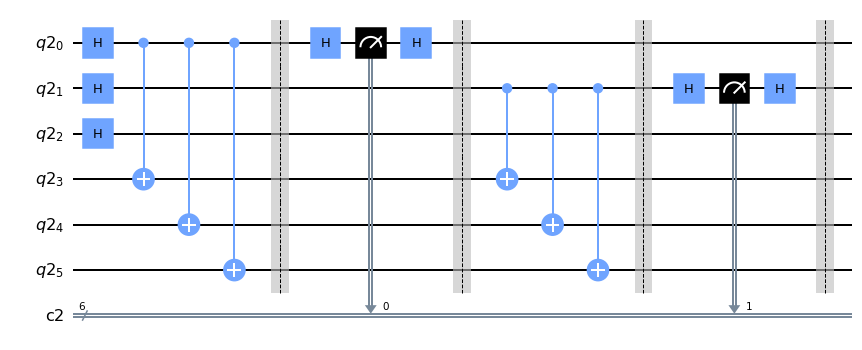

In [38]:
SCC.draw(output = 'mpl')

Notice, if we were to have the circuit layout "over the surface" similar to the picture where we defined what a star syndrom measurement was. The above "staff notation" resembles music notation moreso that a surface code circuit eminating from a surface (a torus in this example). 

## Face Syndrome Measurements
Next, we will define the **face (or plaquette) syndrome measurement** shown on the left of the image below.

![Star_Syndrome](star_syndrome.png "Star_Syndrome")

In [39]:
def face_syndrome_measure(circuit: qiskit.circuit.QuantumCircuit, surface_graph: nx.MultiGraph,
                          node_info,
                          vertex: Tuple[int]):
    v = vertex
    sigma_dict, alpha_dict, phi_dict = node_info
    for node in surface_graph.neighbors(v):
        circuit.cz(phi_dict[v], alpha_dict[node])

    circuit.barrier()
    x_measurement(circuit, phi_dict[v], phi_dict[v])
    circuit.barrier()

    return circuit, surface_graph, node_info

We can use the face vertex $(0,5,1,3,2,4)$ to perform a face syndrome measurement on the correspodning qubit. Notice the face syndrome measurements have controlled-$Z$ gates rather than `CNOT` gates like the star syndrome measurements have. 

In [40]:
u = (0,5,1,3,2,4)
SCC, G, node_info = face_syndrome_measure(SCC, G, node_info, u)

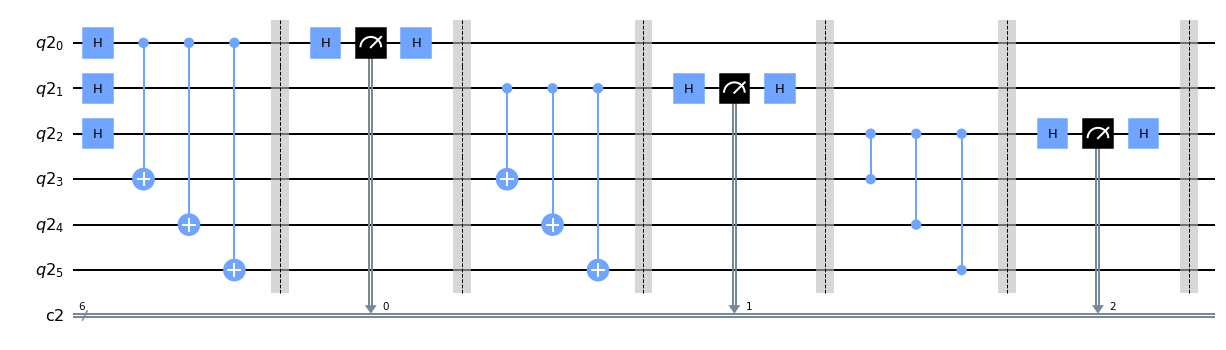

In [41]:
SCC.draw(output = 'mpl')

## Surface Code Functions

Below we give a summary of the functions we have built for surface codes. 

In [42]:
from typing import Tuple, List, Union, Any, Dict

#from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
#from qiskit.circuit.measure import measure
#from networkx import nx
#import qiskit
#from sympy.combinatorics import Permutation


import networkx as nx
from networkx.classes.multigraph import MultiGraph
from networkx.algorithms import bipartite
from sympy.combinatorics import Permutation, PermutationGroup
from qiskit import *


def x_measurement(circuit: qiskit.circuit.QuantumCircuit, qubit: int, cbit: int):
    """Measure 'qubit' in the X-basis, and store the result in 'cbit'"""
    # circuit.measure = measure  # fix a bug in qiskit.circuit.measure
    circuit.h(qubit)
    circuit.measure(qubit, cbit)
    circuit.h(qubit)
    return circuit


def compute_phi(sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]) -> List[List[int]]:
    """compute the list of lists full cyclic form of phi (faces of dessin [sigma, alpha, phi])"""
    s = Permutation(sigma)
    a = Permutation(alpha)
    f = ~(a * s)
    f = f.full_cyclic_form # prints permutation as a list of lists including all singletons (fixed points)
    return f


def permlist_to_tuple(perms):
    """
    convert list of lists to tuple of tuples in order to have two level iterables
    that are hashable for the dictionaries used later
    """
    perm_list = list()
    for perm in perms:
        perm = tuple(perm)
        perm_list.append(perm)
    return tuple(perm_list)


def build_node_info(sigma, alpha, phi):
    count = -1
    
    sigma_dict = dict()
    for count, cycle in enumerate(sigma):
        sigma_dict[cycle] = count
        
    phi_dict = dict()
    for count, cycle in enumerate(phi, start=count + 1):
        phi_dict[cycle] = count
        
    alpha_dict = dict()
    for count, pair in enumerate(alpha, start=count + 1):
        alpha_dict[pair] = count
        
    return sigma_dict, alpha_dict, phi_dict


def surface_code_graph(sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]) -> \
        Tuple[Union[nx.MultiGraph, Any], Tuple[Dict[Any, int], Dict[Any, int], Dict[Any, int]]]:
    """output a graph and a node_info"""
    f = compute_phi(sigma, alpha)
    phi = permlist_to_tuple(f)

    surface_graph = nx.MultiGraph()

    node_info = build_node_info(sigma, alpha, phi)

    # Create nodes for each cycle in sigma
    for cycle in sigma:
        surface_graph.add_node(cycle, bipartite=1)
        for node in cycle:
            surface_graph.add_node(node, bipartite=0)
            surface_graph.add_edge(cycle, node)

    # Create nodes for each cycle in phi
    for cycle in phi:
        surface_graph.add_node(cycle, bipartite=1)
        for node in cycle:
            surface_graph.add_edge(cycle, node)

    # Create nodes for each cycle in alpha
    # then glue the nodes corresponding to a the pairs
    for pair in alpha:
        surface_graph.add_node(pair)
        surface_graph = nx.contracted_nodes(surface_graph, pair[0], pair[1], self_loops=True)
        surface_graph = nx.contracted_nodes(surface_graph, pair, pair[0], self_loops=True)

    return surface_graph, node_info


def surface_code_circuit(sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]) -> \
        Tuple[QuantumCircuit, Union[nx.MultiGraph, Any], Tuple[Dict[Any, int], Dict[Any, int], Dict[Any, int]]]:
    
    surface_graph, node_info = surface_code_graph(sigma, alpha)

    '''
    Compute the permutation corresponding to phi and create a 
    'surface code circuit' based on a (multi)graph 'surface_graph'
    given by sigma, alpha, and phi
    Create quantum and classical registers based on the number of nodes in G
    '''
    f = compute_phi(sigma, alpha)
    phi = permlist_to_tuple(f)

    qr = QuantumRegister(len(surface_graph.nodes))
    cr = ClassicalRegister(len(surface_graph.nodes))
    circ = QuantumCircuit(qr, cr)
    
    sigma_dict, alpha_dict, phi_dict = node_info
    
    for cycle in sigma:
        circ.h(sigma_dict[cycle])

    for cycle in phi:
        circ.h(phi_dict[cycle])

    return circ, surface_graph, node_info


def star_syndrome_measure(circuit: qiskit.circuit.QuantumCircuit, surface_graph: nx.MultiGraph,
                          node_info, vertex: Tuple[int]):
    v = vertex
    
    sigma_dict, alpha_dict, phi_dict = node_info
    
    for node in surface_graph.neighbors(v):
        circuit.cx(sigma_dict[v], alpha_dict[node])

    circuit.barrier()
    x_measurement(circuit, sigma_dict[v], sigma_dict[v])
    circuit.barrier()

    return circuit, surface_graph, node_info


def face_syndrome_measure(circuit: qiskit.circuit.QuantumCircuit, surface_graph: nx.MultiGraph,
                          node_info,
                          vertex: Tuple[int]):
    v = vertex
    sigma_dict, alpha_dict, phi_dict = node_info
    for node in surface_graph.neighbors(v):
        circuit.cz(phi_dict[v], alpha_dict[node])

    circuit.barrier()
    x_measurement(circuit, phi_dict[v], phi_dict[v])
    circuit.barrier()

    return circuit, surface_graph, node_info

Any $2$-dimensional topological error correcting code can be represented as a surface code such as those we have constructed so far. We will eventually construct hybrid qudit codes, but for now, we stay with using qubits for each node in the graphs embedded in surfaces. It is important to now turn to constructing and studying some of the topological properties of these codes. 

## Boundary and Coboundary Operators for Surface Code Graphs

Next, we need to define "boundary operators" on dessins/surface code graphs. Boundary operators act on "chains" and for us, chains will be lists of faces, edges, or vertices. They can be thought of as elements in a vector space over $\mathbb{Z}/2\mathbb{Z}$, but this can be interpreted as the element either being present in the list (coefficient $1$) or not in the list (coefficient $0$). So we don't really need to use the linear algebra perspective yet. The boundary operator $\partial_2:F \to E$ (faces to edges) takes faces to the edges that surround them, i.e. to the boundary of the face. Similarly, the boundary operator $\partial_1:E \to V$ (edges to vertices) take edges to the vertices attached to their ends. The boundary of a vertex (node) in a surface code graph is always $0$. Remember for a constellation $[\sigma, \alpha, \phi]$ we get a bipartite graph on a surface. Now, we will consider the "white nodes" labeled by pairs in $\alpha$ as the edge labels. The black nodes labeled by $\phi$ in the surface code graph will be the "faces". The black nodes labeled by $\sigma$ will be the "vertices".

There is also a "coboundary" operator $\delta_2:E \to F$ (edges to faces) that computes the faces lying on either side of an edge. For the "stars" of the graph labeled by $\sigma$ there is a coboundary operator $\delta_1:V \to E$ (vertices to edges) which computes the edges attached to a vertex labeled by $\sigma$. The two boundary operators that will be most important and used most often will be $\partial_2$ and $\delta_1$ operating on faces and stars respectively, but we're going to define all four of the boundary and coboundary operators.

The boundary and coboundary operators  can then be used to define Pauli-operators corresponding to cycles and cocyles in the surface code graph. We will discuss this more once we have defined the boundary and coboundary operators. Let's start by defining $\partial_2$ and $\delta_1$.

In [43]:
from collections import Counter

def boundary_2(face, surface_code_graph):
    boundary = surface_code_graph.neighbors(face)
    return boundary


def del_2(faces, surface_code_graph):
    boundary_list = list()
    for face in faces:
        boundary = boundary_2(face, surface_code_graph)
        boundary_list.append(boundary)
    a = Counter([y for x in boundary_list for y in x])
    #mod 2 arithmetic here, can be changed to Z/nZ or Z
    boundary_list = [x[0] for x in a.items() if x[1]%2==1]
    return boundary_list


def coboundary_1(star, surface_code_graph):
    coboundary = surface_code_graph.neighbors(star)
    return coboundary


def delta_1(stars, surface_code_graph):
    coboundary_list = list()
    for star in stars:
        coboundary = coboundary_1(star, surface_code_graph)
        coboundary_list.append(coboundary)
    a = Counter([y for x in coboundary_list for y in x])
    #mod 2 arithmetic here, can be changed to Z/nZ or Z
    coboundary_list = [x[0] for x in a.items() if x[1]%2==1]
    return coboundary_list

Now, let's look at some example applications of these operators on a surface code graph.

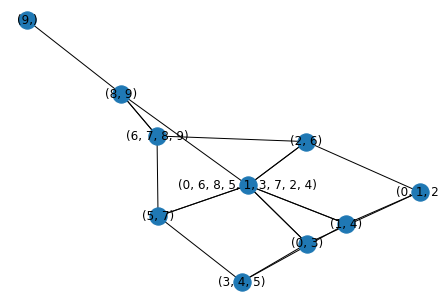

In [44]:
sigma = ((0,1,2), (3,4,5), (6,7,8,9))
alpha = ((0,3),(1,4),(2,6),(5,7),(8,9))
G, node_info = surface_code_graph(sigma, alpha)
nx.draw(G, with_labels = True)

Let's get the `node_info` so we know what the dictionaries for $[\sigma, \alpha, \phi]$ are. 

In [45]:
node_info

({(0, 1, 2): 0, (3, 4, 5): 1, (6, 7, 8, 9): 2},
 {(0, 3): 5, (1, 4): 6, (2, 6): 7, (5, 7): 8, (8, 9): 9},
 {(0, 6, 8, 5, 1, 3, 7, 2, 4): 3, (9,): 4})

Next, we define `faces` and compute the boundary of this list of faces.

In [46]:
faces = [(0, 6, 8, 5, 1, 3, 7, 2, 4), (9,)]
del_2(faces, G)

[(0, 3), (1, 4), (2, 6), (5, 7)]

Finally, we can compute the coboundary of two vertices given by two of the cycles from $\sigma$. 

In [47]:
stars = [(0,1,2), (3,4,5)]
delta_1(stars, G)

[(2, 6), (5, 7)]

The following image illustrates how this works for the square lattice on a torus, unfortunately there is little in the literature on arbitrary graphs embedded in surfaces. The concept is the same however, and if your graph happens to be a square lattice on a torus, then you have reproduced Kitaev's torus code. For more on this particular code see the [Error Correction Zoo](https://errorcorrectionzoo.org/c/surface).

![Strings](strings.png "strings")

Our examples are more complicated graph embeddings than just a regular square lattice. We might have something that looks more like the hyperbolic codes mentioned in [Homological Quantum Codes
Beyond the Toric Code](https://arxiv.org/pdf/1802.01520.pdf) and pictured in the following image, 

![graph_on_surface](graph_on_surface.png "graph_on_surface")

The strings of operators used to generate logical operators or to simulate error propogation might be more complicated too. Fortunately we can still handle the mathematics even if it is difficult to draw. 

It is important to note that if our list of faces or stars in given as input for the above two functions has faces with edges in common, an even number of occurences of the same edge means that edge doesn't show up in the output. On the other hand if there are an odd number of occurence of an edge, that edge does show up in the output. This reflects the $\mathbb{Z}/2\mathbb{Z}$-chain complex structure. This can all be phrased in terms of linear algebra and treating $V$, $E$, and $F$ as vector spaces over $\mathbb{Z}/2\mathbb{Z}$. For more background on the math involved see Chapter 3 of [Quantum Computation with Topological Codes: from qubit to topological fault-tolerance](https://arxiv.org/pdf/1504.01444.pdf).

At this point we should mention that a list of faces will forms a $2$-chain, and a list of stars (vertices in $\sigma$) forms a $0$-cochain. From this, aloing with the boundary and coboundary operators we just defined, we can define the Pauli product operators. The first kind of Pauli product operators we define are 

\begin{align}
W(c_1) = \bigotimes_{k}W(e_k)^{n(k)},
\end{align}

where $n(k) \in \{0,1\}$, and $c_1$ is a "$1$-chain" given by a list of edges (each edge corresponding to a pair in $\alpha$). Each $W_k \in \{X_k, Y_k, Z_k\}$ is a Pauli operator that operates on the $k^{th}$ qubit, where $k$ is the index of the qubit corresponding to an edge. We have can get this index using `node_info`, in particular `alpha_dict`, the middle dictionary, gives us the indices of qubits corresponding to each edge. 

Now, if we compute the boundary $\partial_2(c_2)$ of a $2$-chain (given by a list of faces), we will get a $1$-chain. This $1$-chain will be a list of edges that form the boundary of the faces. From this, we can compute the "**plaquette operators**", i.e. **face operators**, 

\begin{align}
Z(\partial_2f_k) = \bigotimes_{e_j \in \partial_2f_k} Z(e_j)
\end{align}

where $\partial_2f_k$ is the edge list forming the boundary of the face $f_k \in F$. We can also computer the "**star operators**", 

\begin{align}
X(\delta_1 v_m) = \bigotimes_{e_j \in \delta_1v_m} X(e_j), 
\end{align}

where $\delta_1 v_m$ is the edge list forming the *coboundary* of the vertex $v_m$ (which corresponds to some cycle permutation in $\sigma$). These form the **stabilizer generators** for the surface code. For a refresher on stabilizer generators we refer to the notebooks on [error correction](https://github.com/The-Singularity-Research/error-correction) and on [graph states](https://github.com/The-Singularity-Research/graph-state-quantum-cryptography/blob/master/certifying_graph_states.ipynb). Now, let's define a Pauli product $Z$ operator $Z(\partial_2 c_2)$ for the boundary of an arbitray $2$-chain $c_2$, as well as a Pauli product $X$ operator $X(\delta_1 c_0)$ for the coboundary of an arbitrary $0$-cochain $c_0$. 

In [48]:
'''
Pauli product Z operator for arbitrary 2-chain boundary
'''
def product_Z(faces, surface_code_circuit, surface_code_graph, node_info):
    sigma_dict, alpha_dict, phi_dict = node_info
    boundary_nodes = del_2(faces, surface_code_graph)
    circ = surface_code_circuit
    for node in boundary_nodes:
        circ.z(alpha_dict[node])
    return circ


'''
Pauli product X operator for arbitrary 0-cochain coboundary
'''
def product_X(stars, surface_code_circuit, surface_code_graph, node_info):
    sigma_dict, alpha_dict, phi_dict = node_info
    coboundary_nodes = delta_1(stars, surface_code_graph)
    circ = surface_code_circuit
    for node in coboundary_nodes:
        circ.x(alpha_dict[node])
    return circ

In [49]:
sigma = ((0,1,2), (3,4,5), (6,7,8,9))
alpha = ((0,3),(1,4),(2,6),(5,7),(8,9))
SCC, G, node_info = surface_code_circuit(sigma, alpha)
# SCC.draw(output = 'mpl')

In [50]:
faces = [(0, 6, 8, 5, 1, 3, 7, 2, 4)]
SCC = product_Z(faces, SCC, G, node_info)

In [51]:
stars = [(0,1,2), (3,4,5)]
delta_1(stars, G)

[(2, 6), (5, 7)]

In [52]:
node_info

({(0, 1, 2): 0, (3, 4, 5): 1, (6, 7, 8, 9): 2},
 {(0, 3): 5, (1, 4): 6, (2, 6): 7, (5, 7): 8, (8, 9): 9},
 {(0, 6, 8, 5, 1, 3, 7, 2, 4): 3, (9,): 4})

In [53]:
stars = [(0,1,2), (3,4,5)]
SCC = product_X(stars, SCC, G, node_info)

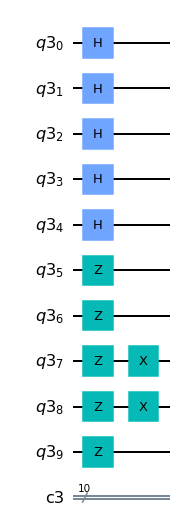

In [54]:
SCC.draw(output = 'mpl')

As a future development we will need to implement general qudits in Qiskit in order to build hybrid qudit surface codes. An alternatre approach would be to use Google Cirq as there is functionality for qudits of arbitrary dimension. 

## References

#### Primary
[Graphs on Surfaces and Their Applications](https://www-users.cse.umn.edu/~reiner/Classes/Math8680Fall2014Papers/LandoZvonkin.pdf)

[Quantum Computation with Topological Codes
— from qubit to topological fault-tolerance —](https://arxiv.org/pdf/1504.01444.pdf)

#### Secondary

[Homological Quantum Codes
Beyond the Toric Code](https://arxiv.org/pdf/1802.01520.pdf)